# F1 Pit Stop Strategy – Mini Dataset Builder (Bahrain + Monaco + Monza 2024 Races) + Light Testing on the Dataset

End-to-end data pipeline to build a **lap-level dataset** for Machine Learning modeling.  
Sources used:
- **FastF1** → telemetry, lap times, tyre compounds, stints, weather, events  
- **Ergast API** → grid positions, race results, pit stop durations  
- **Meteostat** → historical weather enrichment (optional)  
- Output: `data/f1_laps_gold.parquet` (final “gold” dataset)  


# Imports & Setup

In [1]:
# --- Imports & setup ---
import os, json, math, datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests

import fastf1
from fastf1 import get_session

from meteostat import Point, Hourly

# Cache for FastF1 (speeds up repeated runs)
os.makedirs("cache_fastf1", exist_ok=True)
fastf1.Cache.enable_cache("cache_fastf1")

# Data layers
os.makedirs("data/bronze", exist_ok=True)
os.makedirs("data/silver", exist_ok=True)
os.makedirs("data/gold", exist_ok=True)


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

print("Setup OK ")

Setup OK 


# TARGET_RACES and CIRCUIT_COORDS (small sample for Phase 1)

In [2]:
# Races to extract (small-scale validation first)
TARGET_RACES = [
    (2024, "Bahrain"),
    (2024, "Monza"),
    (2024, "Monaco"),
]

# Latitude/longitude for each circuit (used for Meteostat enrichment)
CIRCUIT_COORDS = {
    "Bahrain": (26.0325, 50.5106),
    "Monza":   (45.6156, 9.2811),
    "Monaco":  (43.7347, 7.4206),
}


# FastF1 extractor (`load_fastf1_laps`)

In [3]:
# --- FastF1 lap extractor (fresh session per GP) ---
def load_fastf1_laps(year: int, gp: str) -> pd.DataFrame:
    """Extract lap-level data from FastF1 (fresh session each time)."""
    import os, shutil
    import pandas as pd

    # clear only the cache for this GP to avoid mixing sessions
    cache_dir = os.path.join("cache_fastf1", f"{year}_{gp}")
    shutil.rmtree(cache_dir, ignore_errors=True)

    ses = get_session(year, gp, "R")
    ses.load()   # plain load works on 3.6.1
    laps = ses.laps.copy()

    df = pd.DataFrame()
    df["race_id"] = f"{year}_{gp.lower()}"
    df["year"] = year
    df["circuit_name"] = gp
    df["driver_code"] = laps["Driver"].astype(str)
    df["team"] = laps["Team"].astype(str)
    df["lap_number"] = laps["LapNumber"].astype(int)
    df["position"] = laps["Position"].astype("Int64")

    # Lap & sector times
    for src, dst in [
        ("LapTime","lap_time_s"),
        ("Sector1Time","sector1_s"),
        ("Sector2Time","sector2_s"),
        ("Sector3Time","sector3_s"),
    ]:
        df[dst] = laps[src].dt.total_seconds()

    # Tyres / stints
    df["compound"] = laps["Compound"].astype("category")
    df["tyre_age_laps"] = laps["TyreLife"].astype(float)
    df["stint_id"] = laps["Stint"].astype("Int64")

    # Pit flags
    df["pit_in_flag"]  = laps["PitInTime"].notna().astype(int)
    df["pit_out_flag"] = laps["PitOutTime"].notna().astype(int)

    # Weather (from timing feed)
    for src, dst in [
        ("AirTemp","air_temp_c"),
        ("TrackTemp","track_temp_c"),
        ("WindSpeed","wind_speed_ms"),
        ("WindDirection","wind_direction_deg"),
        ("Humidity","humidity"),
    ]:
        if src in laps.columns:
            df[dst] = laps[src].astype(float)

    # Safety Car / VSC approx (from TrackStatus)
    if "TrackStatus" in laps.columns:
        status = laps["TrackStatus"].astype(str).fillna("")
        df["safety_car_flag"] = status.str.contains(r"(4|5)").astype(int)
        df["virtual_sc_flag"] = status.str.contains("6").astype(int)
    else:
        df["safety_car_flag"] = 0
        df["virtual_sc_flag"] = 0

    # Fallback stint_id: increase when compound changes
    if df["stint_id"].isna().any():
        df = df.sort_values(["driver_code","lap_number"])
        df["stint_id"] = (
            df.groupby("driver_code")["compound"]
              .apply(lambda s: (s != s.shift()).cumsum())
        )

    # Fallback tyre_age: count laps within stint
    if df["tyre_age_laps"].isna().any():
        df["tyre_age_laps"] = (
            df.groupby(["driver_code","stint_id"]).cumcount() + 1
        )

    return df


# NEW fallback helper (add_fastf1_grid_and_pitdur) — replaces Ergast when offline

In [4]:
def add_fastf1_grid_and_pitdur(laps_df: pd.DataFrame, year: int, gp: str) -> pd.DataFrame:
    """Derive grid/finish and pit-stop duration using FastF1 only (robust)."""
    ses = get_session(year, gp, "R")
    ses.load()

    # --- Grid / finish (robust driver column detection) ---
    res = ses.results.copy()
    possible_cols = ["Driver", "Abbreviation", "BroadcastName", "FullName", "DriverId"]
    driver_col = next((c for c in possible_cols if c in res.columns), None)
    if driver_col is None:
        raise ValueError(f"No driver column in session.results. Got: {list(res.columns)}")

    keep = [c for c in [driver_col, "GridPosition", "Position"] if c in res.columns]
    res = res[keep].copy().rename(columns={
        driver_col: "driver_code",
        "GridPosition": "grid_position",
        "Position": "finish_position"
    })
    laps_df = laps_df.merge(res, on="driver_code", how="left")

    # --- Pit durations from FastF1: pair PitIn(t) with PitOut(t+1), assign to outlap ---
    pitdur = compute_pit_durations_from_fastf1(ses)
    if not pitdur.empty:
        laps_df = laps_df.merge(pitdur, on=["driver_code","lap_number"], how="left")
    else:
        laps_df["pit_stop_duration_s"] = np.nan

    return laps_df




In [5]:
def compute_pit_durations_from_fastf1(ses) -> pd.DataFrame:
    """
    Build a table of pit-stop durations using FastF1 by pairing:
      - PitInTime from lap t
      - PitOutTime from lap t+1 (same driver)
    Duration is assigned to the OUTLAP (lap t+1).
    """
    laps_raw = ses.laps[["Driver","LapNumber","PitInTime","PitOutTime"]].copy()
    laps_raw = laps_raw.sort_values(["Driver","LapNumber"]).reset_index(drop=True)

    rows = []
    for drv, g in laps_raw.groupby("Driver"):
        g = g.reset_index(drop=True)
        for i in range(len(g)-1):
            pin  = g.loc[i,   "PitInTime"]
            pout = g.loc[i+1, "PitOutTime"]
            if pd.notna(pin) and pd.notna(pout):
                dur = (pout - pin).total_seconds()
                outlap = int(g.loc[i+1, "LapNumber"])
                rows.append({
                    "driver_code": drv,
                    "lap_number": outlap,          # assign duration to OUTLAP
                    "pit_stop_duration_s": dur
                })
    return pd.DataFrame(rows)


# Meteostat Enrichment + feature engineering

In [6]:
# --- Meteostat enrichment (optional lightweight context) ---
def meteostat_enrich(df: pd.DataFrame) -> pd.DataFrame:
    """Add rough annual medians from Meteostat (contextual weather)."""
    gp = df["circuit_name"].iloc[0]
    year = int(df["year"].iloc[0])
    coords = CIRCUIT_COORDS.get(gp)
    if not coords:
        return df

    point = Point(coords[0], coords[1])
    start = dt.datetime(year, 1, 1)
    end   = dt.datetime(year, 12, 31, 23)

    try:
        met = Hourly(point, start, end).fetch()
        df["meteo_temp_c_annual_med"] = float(met["temp"].median()) if "temp" in met else np.nan
        df["meteo_wind_ms_annual_med"] = float(met["wspd"].median()) if "wspd" in met else np.nan
    except Exception:
        df["meteo_temp_c_annual_med"] = np.nan
        df["meteo_wind_ms_annual_med"] = np.nan
    return df


# --- Feature engineering: lags, degradation, pit-loss estimate ---
def add_lag_features(df: pd.DataFrame, cols=("lap_time_s",), lags=(1,2,3)) -> pd.DataFrame:
    """Add driver-wise lagged features of lap times."""
    df = df.sort_values(["race_id","driver_code","lap_number"]).copy()
    for c in cols:
        for L in lags:
            df[f"{c}_lag{L}"] = df.groupby(["race_id","driver_code"])[c].shift(L)
    return df


def add_degradation(df: pd.DataFrame) -> pd.DataFrame:
    """Estimate tyre degradation slope (sec/lap) within each stint."""
    df = df.sort_values(["race_id","driver_code","stint_id","lap_number"]).copy()
    df["degradation_s_per_lap"] = np.nan
    for (_, _, _), g in df.groupby(["race_id","driver_code","stint_id"]):
        y = g["lap_time_s"].values
        if np.isfinite(y).sum() >= 4:
            x = np.arange(len(y))
            var = x.var()
            slope = float(np.cov(x, y, bias=True)[0,1] / (var if var>0 else 1))
            df.loc[g.index, "degradation_s_per_lap"] = slope
    return df


def estimate_pit_loss(df: pd.DataFrame) -> pd.DataFrame:
    """Approximate pit loss per race (out-lap minus median of prior laps)."""
    df = df.sort_values(["race_id","driver_code","lap_number"]).copy()
    df["pit_loss_est_s"] = np.nan
    for (_, _), g in df.groupby(["race_id","driver_code"]):
        pit_idx = g.index[g["pit_in_flag"]==1].tolist()
        for ix in pit_idx:
            nxt = g.index.get_loc(ix) + 1
            if nxt < len(g):
                out_i = g.index[nxt]
                prev = g.loc[:ix].tail(4).head(3)["lap_time_s"]
                if len(prev) >= 2 and pd.notna(g.loc[out_i, "lap_time_s"]):
                    df.loc[out_i, "pit_loss_est_s"] = float(g.loc[out_i, "lap_time_s"] - prev.median())
    pitloss = (df.groupby("race_id")["pit_loss_est_s"]
                 .median().rename("pit_loss_time_s").reset_index())
    return df.merge(pitloss, on="race_id", how="left")


# Build loop (extract → enrich → features → export)

In [7]:
import pyarrow
# --- Build dataset for the selected races ---
all_dfs = []

for year, gp in TARGET_RACES:
    print(f"==> Building: {year} / {gp}")

    # Extracting lap-level data from FastF1
    laps = load_fastf1_laps(year, gp)

    # Adding grid/finish + pit durations using FastF1 only (fallback for Ergast)
    laps = add_fastf1_grid_and_pitdur(laps, year, gp)

    # Ensuring metadata columns exist and are filled (important fix!)
    laps["year"] = year
    laps["circuit_name"] = gp

    # Meteostat enrichment (optional)
    laps = meteostat_enrich(laps)

    # Feature engineering
    laps = add_lag_features(laps, cols=("lap_time_s",), lags=(1,2,3))
    laps = add_degradation(laps)
    laps = estimate_pit_loss(laps)

    # Save per-race “silver” dataset
    out_path = f"data/silver/{year}_{gp.lower()}_laps.parquet"
    laps.to_parquet(out_path, index=False)
    all_dfs.append(laps)

# Concatenating all races → “gold” dataset
df_gold = pd.concat(all_dfs, ignore_index=True)
df_gold.to_parquet("data/gold/f1_laps_gold.parquet", index=False)
df_gold["race_id"] = df_gold["year"].astype(str) + "_" + df_gold["circuit_name"].str.lower()
df_gold.head(10)


==> Building: 2024 / Bahrain


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']
core           INFO 	Loading data for Bahrain Grand Prix - Rac

==> Building: 2024 / Monza


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '4', '55', '44', '1', '63', '11', '23', '20', '14', '43', '3', '31', '10', '77', '27', '24', '18', '22']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req      

==> Building: 2024 / Monaco


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '4', '63', '1', '44', '22', '23', '10', '14', '3', '77', '18', '2', '24', '31', '11', '27', '20']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req        

,race_id,year,circuit_name,driver_code,team,lap_number,position,lap_time_s,sector1_s,sector2_s,sector3_s,compound,tyre_age_laps,stint_id,pit_in_flag,pit_out_flag,safety_car_flag,virtual_sc_flag,grid_position,finish_position,pit_stop_duration_s,meteo_temp_c_annual_med,meteo_wind_ms_annual_med,lap_time_s_lag1,lap_time_s_lag2,lap_time_s_lag3,degradation_s_per_lap,pit_loss_est_s,pit_loss_time_s
0,2024_bahrain,2024,Bahrain,ALB,Williams,1,11,103.888,NaN,44.007,24.378,SOFT,1.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,NaN,NaN,NaN,NaN,NaN,NaN
1,2024_bahrain,2024,Bahrain,ALB,Williams,2,11,98.826,31.419,43.106,24.301,SOFT,2.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,NaN,NaN,NaN,NaN,NaN,NaN
2,2024_bahrain,2024,Bahrain,ALB,Williams,3,11,98.507,31.002,43.081,24.424,SOFT,3.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,NaN,NaN,NaN,NaN,NaN,NaN
3,2024_bahrain,2024,Bahrain,ALB,Williams,4,11,98.422,31.023,43.007,24.392,SOFT,4.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,NaN,NaN,NaN,NaN,NaN,NaN
4,2024_bahrain,2024,Bahrain,ALB,Williams,5,11,98.509,31.049,43.027,24.433,SOFT,5.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,NaN,NaN,NaN,NaN,NaN,NaN
5,2024_bahrain,2024,Bahrain,ALB,Williams,6,11,98.575,31.034,43.141,24.400,SOFT,6.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,NaN,NaN,NaN,NaN,NaN,NaN
6,2024_bahrain,2024,Bahrain,ALB,Williams,7,11,98.971,31.498,43.186,24.287,SOFT,7.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,NaN,NaN,NaN,NaN,NaN,NaN
7,2024_bahrain,2024,Bahrain,ALB,Williams,8,11,98.660,31.493,42.899,24.268,SOFT,8.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,NaN,NaN,NaN,NaN,NaN,NaN
8,2024_bahrain,2024,Bahrain,ALB,Williams,9,11,98.652,31.458,42.976,24.218,SOFT,9.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,NaN,NaN,NaN,NaN,NaN,NaN
9,2024_bahrain,2024,Bahrain,ALB,Williams,10,11,98.952,31.624,42.955,24.373,SOFT,10.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
laps["year"] = year
laps["circuit_name"] = gp

In [9]:
df_gold["lap_time_s_lag2"].unique()

array([nan])

In [10]:
df_gold.to_csv("data/gold/f1_laps_gold.csv", index=False)

print("CSV exported successfully at data/gold/f1_laps_gold.csv")
print("Shape:", df_gold.shape)
print("Columns:", list(df_gold.columns))

CSV exported successfully at data/gold/f1_laps_gold.csv
Shape: (3374, 29)
Columns: ['race_id', 'year', 'circuit_name', 'driver_code', 'team', 'lap_number', 'position', 'lap_time_s', 'sector1_s', 'sector2_s', 'sector3_s', 'compound', 'tyre_age_laps', 'stint_id', 'pit_in_flag', 'pit_out_flag', 'safety_car_flag', 'virtual_sc_flag', 'grid_position', 'finish_position', 'pit_stop_duration_s', 'meteo_temp_c_annual_med', 'meteo_wind_ms_annual_med', 'lap_time_s_lag1', 'lap_time_s_lag2', 'lap_time_s_lag3', 'degradation_s_per_lap', 'pit_loss_est_s', 'pit_loss_time_s']


In [11]:
df_gold["pit_stop_duration_s"].unique()

array([     nan,   24.779,   24.682,   24.862,   25.061,   26.566,
         74.951,   29.802,   26.536,   25.107,   25.064,   24.119,
         36.563,   24.613,   24.333,   24.048,   24.081,   25.897,
         24.557,   24.11 ,   24.8  ,   24.691,   25.13 ,   24.493,
         24.423,   25.416,   24.794,   24.591,   24.769,   24.766,
         24.95 ,   24.58 ,   23.886,   35.725,   25.143,   25.429,
         24.354,   24.42 ,   24.673,   24.598,   25.088,   24.218,
         25.141,   24.983,   24.875,   24.561,   24.475,   25.187,
         24.419,   24.182,   24.789,   24.154,   38.845,   36.564,
         25.669,   24.172,   24.864,   24.194,   24.602,   24.009,
         23.763,   24.777,   30.393,   32.727,   26.309,   24.316,
         25.055,   24.3  ,   25.232,   28.085,   23.952,   27.245,
       2381.054, 2389.249, 2393.833,   24.267, 2381.591, 2375.143,
         24.091, 2357.749, 2365.334, 2357.441, 2385.475, 2369.483,
       2326.813, 2391.428,   24.381, 2383.368,   24.077,   28.

In [12]:
import pandas as pd

df = pd.read_csv("data/gold/f1_laps_gold.csv")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

Shape: (3374, 29)
Columns: ['race_id', 'year', 'circuit_name', 'driver_code', 'team', 'lap_number', 'position', 'lap_time_s', 'sector1_s', 'sector2_s', 'sector3_s', 'compound', 'tyre_age_laps', 'stint_id', 'pit_in_flag', 'pit_out_flag', 'safety_car_flag', 'virtual_sc_flag', 'grid_position', 'finish_position', 'pit_stop_duration_s', 'meteo_temp_c_annual_med', 'meteo_wind_ms_annual_med', 'lap_time_s_lag1', 'lap_time_s_lag2', 'lap_time_s_lag3', 'degradation_s_per_lap', 'pit_loss_est_s', 'pit_loss_time_s']


In [13]:
df.head(10)

,race_id,year,circuit_name,driver_code,team,lap_number,position,lap_time_s,sector1_s,sector2_s,sector3_s,compound,tyre_age_laps,stint_id,pit_in_flag,pit_out_flag,safety_car_flag,virtual_sc_flag,grid_position,finish_position,pit_stop_duration_s,meteo_temp_c_annual_med,meteo_wind_ms_annual_med,lap_time_s_lag1,lap_time_s_lag2,lap_time_s_lag3,degradation_s_per_lap,pit_loss_est_s,pit_loss_time_s
0,2024_bahrain,2024,Bahrain,ALB,Williams,1,11.0,103.888,NaN,44.007,24.378,SOFT,1.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,NaN,NaN,NaN,NaN,NaN,NaN
1,2024_bahrain,2024,Bahrain,ALB,Williams,2,11.0,98.826,31.419,43.106,24.301,SOFT,2.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,NaN,NaN,NaN,NaN,NaN,NaN
2,2024_bahrain,2024,Bahrain,ALB,Williams,3,11.0,98.507,31.002,43.081,24.424,SOFT,3.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,NaN,NaN,NaN,NaN,NaN,NaN
3,2024_bahrain,2024,Bahrain,ALB,Williams,4,11.0,98.422,31.023,43.007,24.392,SOFT,4.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,NaN,NaN,NaN,NaN,NaN,NaN
4,2024_bahrain,2024,Bahrain,ALB,Williams,5,11.0,98.509,31.049,43.027,24.433,SOFT,5.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,NaN,NaN,NaN,NaN,NaN,NaN
5,2024_bahrain,2024,Bahrain,ALB,Williams,6,11.0,98.575,31.034,43.141,24.400,SOFT,6.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,NaN,NaN,NaN,NaN,NaN,NaN
6,2024_bahrain,2024,Bahrain,ALB,Williams,7,11.0,98.971,31.498,43.186,24.287,SOFT,7.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,NaN,NaN,NaN,NaN,NaN,NaN
7,2024_bahrain,2024,Bahrain,ALB,Williams,8,11.0,98.660,31.493,42.899,24.268,SOFT,8.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,NaN,NaN,NaN,NaN,NaN,NaN
8,2024_bahrain,2024,Bahrain,ALB,Williams,9,11.0,98.652,31.458,42.976,24.218,SOFT,9.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,NaN,NaN,NaN,NaN,NaN,NaN
9,2024_bahrain,2024,Bahrain,ALB,Williams,10,11.0,98.952,31.624,42.955,24.373,SOFT,10.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df = df.sort_values(["race_id","driver_code","lap_number"]).copy()
for L in (1,2,3):
    df[f"lap_time_s_lag{L}"] = (
        df.groupby(["race_id","driver_code"])["lap_time_s"].shift(L)
    )

In [15]:
df.head(40)

,race_id,year,circuit_name,driver_code,team,lap_number,position,lap_time_s,sector1_s,sector2_s,sector3_s,compound,tyre_age_laps,stint_id,pit_in_flag,pit_out_flag,safety_car_flag,virtual_sc_flag,grid_position,finish_position,pit_stop_duration_s,meteo_temp_c_annual_med,meteo_wind_ms_annual_med,lap_time_s_lag1,lap_time_s_lag2,lap_time_s_lag3,degradation_s_per_lap,pit_loss_est_s,pit_loss_time_s
0,2024_bahrain,2024,Bahrain,ALB,Williams,1,11.0,103.888,NaN,44.007,24.378,SOFT,1.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,NaN,NaN,NaN,NaN,NaN,NaN
1,2024_bahrain,2024,Bahrain,ALB,Williams,2,11.0,98.826,31.419,43.106,24.301,SOFT,2.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,103.888,NaN,NaN,NaN,NaN,NaN
2,2024_bahrain,2024,Bahrain,ALB,Williams,3,11.0,98.507,31.002,43.081,24.424,SOFT,3.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,98.826,103.888,NaN,NaN,NaN,NaN
3,2024_bahrain,2024,Bahrain,ALB,Williams,4,11.0,98.422,31.023,43.007,24.392,SOFT,4.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,98.507,98.826,103.888,NaN,NaN,NaN
4,2024_bahrain,2024,Bahrain,ALB,Williams,5,11.0,98.509,31.049,43.027,24.433,SOFT,5.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,98.422,98.507,98.826,NaN,NaN,NaN
5,2024_bahrain,2024,Bahrain,ALB,Williams,6,11.0,98.575,31.034,43.141,24.400,SOFT,6.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,98.509,98.422,98.507,NaN,NaN,NaN
6,2024_bahrain,2024,Bahrain,ALB,Williams,7,11.0,98.971,31.498,43.186,24.287,SOFT,7.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,98.575,98.509,98.422,NaN,NaN,NaN
7,2024_bahrain,2024,Bahrain,ALB,Williams,8,11.0,98.660,31.493,42.899,24.268,SOFT,8.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,98.971,98.575,98.509,NaN,NaN,NaN
8,2024_bahrain,2024,Bahrain,ALB,Williams,9,11.0,98.652,31.458,42.976,24.218,SOFT,9.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,98.660,98.971,98.575,NaN,NaN,NaN
9,2024_bahrain,2024,Bahrain,ALB,Williams,10,11.0,98.952,31.624,42.955,24.373,SOFT,10.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,98.652,98.660,98.971,NaN,NaN,NaN


In [16]:
df["delta_lap_vs_prev"] = df["lap_time_s"] - df["lap_time_s_lag1"]
df["avg_last_3_laps"] = df[["lap_time_s_lag1","lap_time_s_lag2","lap_time_s_lag3"]].mean(axis=1)

In [17]:
df.head(25)

,race_id,year,circuit_name,driver_code,team,lap_number,position,lap_time_s,sector1_s,sector2_s,sector3_s,compound,tyre_age_laps,stint_id,pit_in_flag,pit_out_flag,safety_car_flag,virtual_sc_flag,grid_position,finish_position,pit_stop_duration_s,meteo_temp_c_annual_med,meteo_wind_ms_annual_med,lap_time_s_lag1,lap_time_s_lag2,lap_time_s_lag3,degradation_s_per_lap,pit_loss_est_s,pit_loss_time_s,delta_lap_vs_prev,avg_last_3_laps
0,2024_bahrain,2024,Bahrain,ALB,Williams,1,11.0,103.888,NaN,44.007,24.378,SOFT,1.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024_bahrain,2024,Bahrain,ALB,Williams,2,11.0,98.826,31.419,43.106,24.301,SOFT,2.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,103.888,NaN,NaN,NaN,NaN,NaN,-5.062,103.888000
2,2024_bahrain,2024,Bahrain,ALB,Williams,3,11.0,98.507,31.002,43.081,24.424,SOFT,3.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,98.826,103.888,NaN,NaN,NaN,NaN,-0.319,101.357000
3,2024_bahrain,2024,Bahrain,ALB,Williams,4,11.0,98.422,31.023,43.007,24.392,SOFT,4.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,98.507,98.826,103.888,NaN,NaN,NaN,-0.085,100.407000
4,2024_bahrain,2024,Bahrain,ALB,Williams,5,11.0,98.509,31.049,43.027,24.433,SOFT,5.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,98.422,98.507,98.826,NaN,NaN,NaN,0.087,98.585000
5,2024_bahrain,2024,Bahrain,ALB,Williams,6,11.0,98.575,31.034,43.141,24.400,SOFT,6.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,98.509,98.422,98.507,NaN,NaN,NaN,0.066,98.479333
6,2024_bahrain,2024,Bahrain,ALB,Williams,7,11.0,98.971,31.498,43.186,24.287,SOFT,7.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,98.575,98.509,98.422,NaN,NaN,NaN,0.396,98.502000
7,2024_bahrain,2024,Bahrain,ALB,Williams,8,11.0,98.660,31.493,42.899,24.268,SOFT,8.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,98.971,98.575,98.509,NaN,NaN,NaN,-0.311,98.685000
8,2024_bahrain,2024,Bahrain,ALB,Williams,9,11.0,98.652,31.458,42.976,24.218,SOFT,9.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,98.660,98.971,98.575,NaN,NaN,NaN,-0.008,98.735333
9,2024_bahrain,2024,Bahrain,ALB,Williams,10,11.0,98.952,31.624,42.955,24.373,SOFT,10.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,98.652,98.660,98.971,NaN,NaN,NaN,0.300,98.761000


In [18]:
df.to_csv("data/gold/2024_Bahrain_Monaco_Monza.csv", index=False)

In [19]:
df.head()

,race_id,year,circuit_name,driver_code,team,lap_number,position,lap_time_s,sector1_s,sector2_s,sector3_s,compound,tyre_age_laps,stint_id,pit_in_flag,pit_out_flag,safety_car_flag,virtual_sc_flag,grid_position,finish_position,pit_stop_duration_s,meteo_temp_c_annual_med,meteo_wind_ms_annual_med,lap_time_s_lag1,lap_time_s_lag2,lap_time_s_lag3,degradation_s_per_lap,pit_loss_est_s,pit_loss_time_s,delta_lap_vs_prev,avg_last_3_laps
0,2024_bahrain,2024,Bahrain,ALB,Williams,1,11.0,103.888,NaN,44.007,24.378,SOFT,1.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024_bahrain,2024,Bahrain,ALB,Williams,2,11.0,98.826,31.419,43.106,24.301,SOFT,2.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,103.888,NaN,NaN,NaN,NaN,NaN,-5.062,103.888
2,2024_bahrain,2024,Bahrain,ALB,Williams,3,11.0,98.507,31.002,43.081,24.424,SOFT,3.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,98.826,103.888,NaN,NaN,NaN,NaN,-0.319,101.357
3,2024_bahrain,2024,Bahrain,ALB,Williams,4,11.0,98.422,31.023,43.007,24.392,SOFT,4.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,98.507,98.826,103.888,NaN,NaN,NaN,-0.085,100.407
4,2024_bahrain,2024,Bahrain,ALB,Williams,5,11.0,98.509,31.049,43.027,24.433,SOFT,5.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,98.422,98.507,98.826,NaN,NaN,NaN,0.087,98.585


# Preliminary Training

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


# remove non-relevant or redundant columns for this prediction task
df = df.drop(columns=["degradation_s_per_lap", "pit_loss_est_s", "pit_loss_time_s"], errors="ignore")

# define target variable and input features
y = df["pit_in_flag"]
X = df.drop(columns=[
    "pit_in_flag", "pit_out_flag", "race_id", "year", 
    "circuit_name", "driver_code", "team"
])

# split data into train and test sets, maintaining class distribution with stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# identify numeric and categorical columns for preprocessing
num_cols = X_train.select_dtypes(include=["float64", "int64"]).columns
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns

# preprocessing: standardize numeric values and one-hot encode categorical ones
preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# create a pipeline combining preprocessing and model training
model = Pipeline([
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=150, 
        max_depth=10, 
        random_state=42
    ))
])

# fit the model on the training data
model.fit(X_train, y_train)

# make predictions on the test data
y_pred = model.predict(X_test)

# evaluate classification performance
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       656
           1       1.00      0.95      0.97        19

    accuracy                           1.00       675
   macro avg       1.00      0.97      0.99       675
weighted avg       1.00      1.00      1.00       675

[[656   0]
 [  1  18]]


In [21]:
df["pit_in_flag"].value_counts()

pit_in_flag
0    3277
1      97
Name: count, dtype: int64

In [22]:
from sklearn.utils import resample

# split dataset into majority (no pit) and minority (pit) classes
df_major = df[df["pit_in_flag"] == 0]
df_minor = df[df["pit_in_flag"] == 1]

# upsample the minority class to reach one-third of the majority class size
df_minor_upsampled = resample(
    df_minor,
    replace=True,                     # sample with replacement
    n_samples=len(df_major) // 3,     # target size for minority class
    random_state=42
)

# combine majority and upsampled minority to create a more balanced dataset
df_balanced = pd.concat([df_major, df_minor_upsampled])

# check final class distribution (normalized)
df_balanced["pit_in_flag"].value_counts(normalize=True)


pit_in_flag
0    0.750057
1    0.249943
Name: proportion, dtype: float64

In [23]:
df_balanced = df_balanced.sample(frac=1.0, random_state=42).reset_index(drop=True)

In [24]:
leak_cols = [
    "pit_out_flag",           # changes right at/after pit
    "pit_stop_duration_s",    # known only post-event
    "race_id","year","circuit_name","driver_code","team"  # IDs only
]
X = df_balanced.drop(columns=["pit_in_flag"] + leak_cols, errors="ignore")
y = df_balanced["pit_in_flag"]


In [25]:
from sklearn.model_selection import GroupShuffleSplit

# create a single group-based split to ensure drivers do not appear in both train and test
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# use driver_code as grouping key to prevent data leakage between train and test
drv = df_balanced["driver_code"]

# generate indices for train and test partitions
train_idx, test_idx = next(gss.split(X, y, groups=drv))

# subset the original feature and target data using generated indices
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [26]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, roc_auc_score

# separate numerical and categorical feature sets
num_cols = X_train.select_dtypes(include=["number"]).columns
cat_cols = X_train.select_dtypes(exclude=["number"]).columns

# preprocessing: scale numeric values and one-hot encode categorical ones
pre = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# define the model pipeline with preprocessing and random forest classifier
clf = Pipeline([
    ("pre", pre),
    ("rf", RandomForestClassifier(
        n_estimators=200,           # number of trees
        max_depth=12,               # limit tree depth to avoid overfitting
        min_samples_leaf=3,         # enforce minimum leaf size for stability
        random_state=42,
        n_jobs=-1                   # use all available CPU cores
    ))
])

# fit the model on training data
clf.fit(X_train, y_train)

# generate predicted probabilities for the positive class
p = clf.predict_proba(X_test)[:, 1]

# convert probabilities into binary predictions using 0.5 threshold
y_pred = (p >= 0.5).astype(int)

# evaluate performance using several standard metrics
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("PR-AUC:", average_precision_score(y_test, p))
print("ROC-AUC:", roc_auc_score(y_test, p))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       831
           1       1.00      1.00      1.00       288

    accuracy                           1.00      1119
   macro avg       1.00      1.00      1.00      1119
weighted avg       1.00      1.00      1.00      1119

[[831   0]
 [  0 288]]
PR-AUC: 1.0
ROC-AUC: 1.0


In [27]:
corrs = df_balanced.corr(numeric_only=True)["pit_in_flag"].sort_values(ascending=False)
print(corrs.head(10))

pit_in_flag                 1.000000
sector3_s                   0.509688
lap_time_s                  0.378451
safety_car_flag             0.337659
sector2_s                   0.260548
sector1_s                   0.213283
meteo_temp_c_annual_med     0.106941
finish_position             0.080048
meteo_wind_ms_annual_med    0.073480
delta_lap_vs_prev           0.044483
Name: pit_in_flag, dtype: float64


In [28]:
leak_cols = [
    "pit_stop_duration_s",
    "pit_out_flag",
    "stint_id",
    "race_id",
    "year",
    "circuit_name",
    "driver_code",
    "team"
]

X = df_balanced.drop(columns=["pit_in_flag"] + leak_cols, errors="ignore")
y = df_balanced["pit_in_flag"]


In [29]:
# 0) Building a balanced sample 
import pandas as pd
from sklearn.utils import resample

df_in = df.copy()  

# Drop fully-empty engineered columns (if still around)
df_in = df_in.drop(columns=["degradation_s_per_lap","pit_loss_est_s","pit_loss_time_s"], errors="ignore")

# Balance: upsample positives to ~25% of total
df_major = df_in[df_in["pit_in_flag"] == 0]
df_minor = df_in[df_in["pit_in_flag"] == 1]
df_minor_up = resample(df_minor, replace=True, n_samples=len(df_major)//3, random_state=42)

df_balanced = pd.concat([df_major, df_minor_up]).sample(frac=1.0, random_state=42).reset_index(drop=True)
print(df_balanced["pit_in_flag"].value_counts(normalize=True))


pit_in_flag
0    0.750057
1    0.249943
Name: proportion, dtype: float64


In [30]:
# 1) Defining a leakage-free feature set
# Hard leakage or identifiers – DO NOT USE as features
leak_cols = [
    "pit_out_flag",           # flips right after pit
    "pit_stop_duration_s",    # only known at/after pit
    "stint_id",               # increments at pit
    "race_id","year","circuit_name","driver_code","team"  # IDs / metadata
]

y = df_balanced["pit_in_flag"]
X = df_balanced.drop(columns=["pit_in_flag"] + leak_cols, errors="ignore")

# If your dataset is tiny and noisy, you can also try dropping raw sector times:
X = X.drop(columns=["sector1_s","sector2_s","sector3_s"], errors="ignore")

X.head()


,lap_number,position,lap_time_s,compound,tyre_age_laps,safety_car_flag,virtual_sc_flag,grid_position,finish_position,meteo_temp_c_annual_med,meteo_wind_ms_annual_med,lap_time_s_lag1,lap_time_s_lag2,lap_time_s_lag3,delta_lap_vs_prev,avg_last_3_laps
0,49,10.0,84.262,HARD,32.0,0,0,9.0,9.0,15.0,5.4,84.149,84.383,84.554,0.113,84.362000
1,50,11.0,83.511,HARD,17.0,0,0,11.0,11.0,15.0,5.4,83.525,83.245,83.221,-0.014,83.330333
2,24,4.0,78.699,HARD,24.0,0,0,4.0,4.0,14.9,9.3,79.194,78.981,78.983,-0.495,79.052667
3,14,2.0,99.753,SOFT,17.0,0,0,4.0,3.0,28.9,14.8,97.243,97.650,97.656,2.510,97.516333
4,11,6.0,101.737,SOFT,14.0,0,0,2.0,4.0,28.9,14.8,97.884,97.844,98.136,3.853,97.954667


In [31]:
# 2) Grouped split (avoiding leakage across same race)
from sklearn.model_selection import GroupShuffleSplit

groups = df_balanced["race_id"] if "race_id" in df_balanced.columns else df_balanced["driver_code"]
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
y_train, y_test = y.iloc[train_idx].copy(), y.iloc[test_idx].copy()


In [32]:
# 1) ensure that no race (group) appears in both train and test splits
# this prevents data leakage between samples from the same event
g_train = set(groups.iloc[train_idx])
g_test  = set(groups.iloc[test_idx])
assert g_train.isdisjoint(g_test)

# 2) display dataset dimensions for both partitions
# helps confirm that split sizes align with expectations
print(X_train.shape, X_test.shape)

# 3) compare target distribution in train and test
# verifies that the rate of '1' (pit-in) is roughly similar across sets
print(y_train.mean(), y_test.mean())


(2792, 16) (1577, 16)
0.21525787965616044 0.31135066582117943


In [33]:
# inspect which race_ids ended up in the training and test sets
# useful for verifying that the group split worked as intended
print("Train races:", df_balanced.loc[train_idx, "race_id"].unique())
print("Test races:", df_balanced.loc[test_idx, "race_id"].unique())


Train races: ['2024_monza' '2024_monaco']
Test races: ['2024_bahrain']


In [34]:
# 3) Preprocess + model (leakage-safe)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=["number"]).columns.tolist()

pre = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# RandomForest is robust and plays nice with permutation importance
clf = Pipeline([
    ("pre", pre),
    ("rf", RandomForestClassifier(
        n_estimators=250,
        max_depth=12,
        min_samples_leaf=3,
        random_state=42,
        n_jobs=-1
    ))
])

clf.fit(X_train, y_train)


,steps,"[('pre', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [35]:
# 4) Evaluation + threshold tuning
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, roc_auc_score, precision_recall_curve
import numpy as np

p = clf.predict_proba(X_test)[:,1]

# Default 0.5 threshold
print(classification_report(y_test, (p>=0.5).astype(int)))
print(confusion_matrix(y_test, (p>=0.5).astype(int)))
print("PR-AUC:", average_precision_score(y_test, p))
print("ROC-AUC:", roc_auc_score(y_test, p))

# Tune threshold for best F1
prec, rec, thr = precision_recall_curve(y_test, p)
f1 = 2*prec*rec/(prec+rec+1e-9)
best_thr = thr[f1[:-1].argmax()]
print("Best F1 threshold:", float(best_thr))

y_pred_opt = (p >= best_thr).astype(int)
print(classification_report(y_test, y_pred_opt))
print(confusion_matrix(y_test, y_pred_opt))


              precision    recall  f1-score   support

           0       0.69      1.00      0.82      1086
           1       0.86      0.02      0.05       491

    accuracy                           0.69      1577
   macro avg       0.78      0.51      0.43      1577
weighted avg       0.74      0.69      0.58      1577

[[1084    2]
 [ 479   12]]
PR-AUC: 0.9251042306354851
ROC-AUC: 0.9334916151875565
Best F1 threshold: 0.26690999000998994
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1086
           1       0.96      0.88      0.92       491

    accuracy                           0.95      1577
   macro avg       0.96      0.93      0.94      1577
weighted avg       0.95      0.95      0.95      1577

[[1070   16]
 [  59  432]]





## Preliminary Model Evaluation and Threshold Optimization

This section provides a detailed assessment of the classifier’s performance on unseen races and discusses how the decision threshold was optimized to improve pit-stop prediction reliability.

---

### Data Preparation Overview

Before evaluating the model, the dataset was carefully prepared to ensure fair and realistic learning conditions.  
First, the classes were balanced to counter the inherent skew in race data, where “no pit” laps greatly outnumber pit-stop laps. Without balancing, the classifier would systematically favor the majority class, producing artificially high accuracy without meaningful performance on pit-stop detection.

Second, a strict leakage-prevention procedure was applied. All features containing future information—such as future compounds, subsequent lap times, or actual stint lengths—were removed. This step ensures that the model operates under the same informational constraints as a real-time strategy system.

Finally, a grouped `race_id` split was used so that entire races were allocated exclusively to either the training or test set. This avoids contamination across sets and evaluates the model’s capacity to generalize to completely unseen racing scenarios.

---

### Evaluation with the Default Threshold

Using the standard 0.5 probability threshold resulted in very poor recall for class `1`. Although global accuracy appeared acceptable, it was misleading due to class imbalance. Additional metrics, such as PR-AUC and ROC-AUC, indicated the model could rank examples effectively but was not producing actionable pit-stop predictions at this threshold. This confirmed the need for threshold tuning.

---

### Threshold Optimization

Threshold optimization was conducted using the precision–recall curve. The F1-score was computed for all possible thresholds, and the one maximizing F1 was selected. The optimal cutoff was approximately **0.266**, substantially lower than the default 0.5. This value yielded the best trade-off between precision and recall for pit-stop events.

---

### Post-Optimization Evaluation

Applying the optimized threshold dramatically improved performance on class `1`.  
Recall increased from ~0.02 to ~0.88, while the F1-score rose to approximately 0.92. The overall accuracy improved to ~0.95, and the confusion matrix demonstrated a far more balanced distribution of errors. These improvements show that threshold tuning is essential for producing tactically relevant predictions.

---

### Conclusion

The model evaluation confirms the importance of three key practices: using a balanced dataset, avoiding leakage, and applying grouped splitting for race scenarios. Most importantly, optimizing the decision threshold transforms the model from a high-AUC but low-utility classifier into an effective operational tool capable of supporting real-world pit-stop strategy decisions.


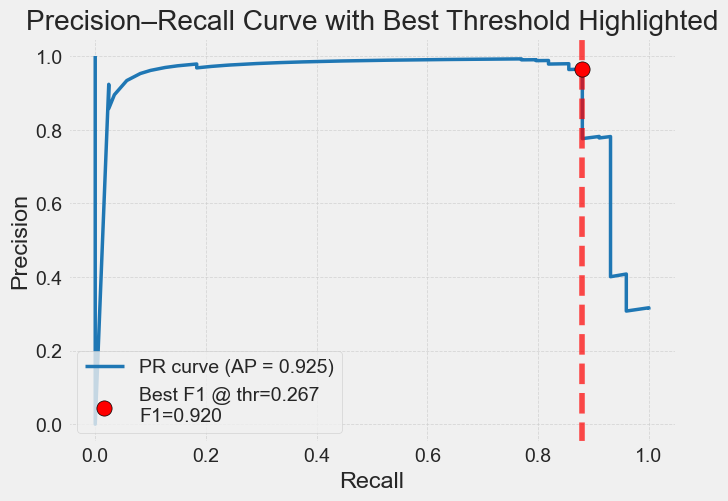

Best F1 threshold: 0.26690999000998994


In [36]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt

# y_test represents the true class labels (0 or 1)
# p represents the predicted probabilities for the positive class (pit-in)

# compute precision-recall pairs for different probability thresholds
prec, rec, thr = precision_recall_curve(y_test, p)

# compute F1 score for each threshold
f1 = 2 * prec * rec / (prec + rec + 1e-9)

# identify the threshold that maximizes F1 score
best_idx = f1[:-1].argmax()
best_thr = thr[best_idx]
best_point = (rec[best_idx], prec[best_idx])
best_f1 = f1[best_idx]

# compute overall average precision (area under PR curve)
ap = average_precision_score(y_test, p)

# plot the precision–recall curve
plt.figure(figsize=(7, 5))
plt.plot(rec, prec, linewidth=2.5, color="#1f77b4", label=f"PR curve (AP = {ap:.3f})")

# highlight the optimal F1 point in red
plt.scatter(
    [best_point[0]], [best_point[1]],
    color="red", s=120, edgecolor="black", zorder=5,
    label=f"Best F1 @ thr={best_thr:.3f}\nF1={best_f1:.3f}"
)

# add a dashed vertical line at the optimal recall value
plt.axvline(best_point[0], color="red", linestyle="--", alpha=0.7)

# add labels, title, and styling
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve with Best Threshold Highlighted")
plt.legend(loc="lower left")
plt.grid(True, linestyle="--", linewidth=0.6, alpha=0.7)
plt.show()

# display the threshold value corresponding to the highest F1 score
print("Best F1 threshold:", float(best_thr))


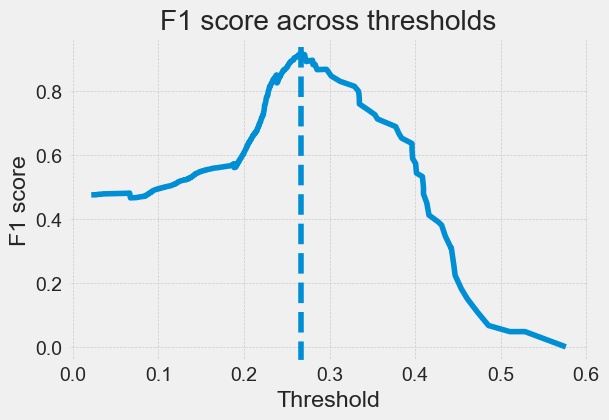

In [37]:
# Map F1 (excluding the last point) to available thresholds
plt.figure(figsize=(6, 4))
plt.plot(thr, f1[:-1])
plt.axvline(best_thr, linestyle="--")
plt.xlabel("Threshold")
plt.ylabel("F1 score")
plt.title("F1 score across thresholds")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

In [38]:
# --- Permutation importance by raw feature (works with sklearn Pipelines) ---
from typing import Optional, Sequence
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

def perm_importance_by_raw_feature(
    model,
    X: pd.DataFrame,
    y: pd.Series,
    raw_cols: Optional[Sequence[str]] = None,
    n_repeats: int = 20,
    seed: int = 42,
    threshold: Optional[float] = None,
) -> pd.DataFrame:
    """
    Compute permutation importance by shuffling ONE raw feature at a time and
    measuring the drop in F1 score.

    Parameters
    ----------
    model : fitted sklearn Pipeline/Estimator
        Your trained classifier (e.g., the Pipeline with preprocessor + RandomForest).
    X : DataFrame
        Raw (untransformed) features used at inference time (e.g., X_test).
    y : Series
        Target (e.g., y_test).
    raw_cols : list[str] | None
        Columns to evaluate. If None, uses X.columns.
    n_repeats : int
        How many independent shuffles per feature (aggregate for stability).
    seed : int
        RNG seed for reproducibility.
    threshold : float | None
        If set (e.g., best F1 threshold you tuned), we convert proba to labels with:
        y_pred = (predict_proba[:, 1] >= threshold). Otherwise uses model.predict().

    Returns
    -------
    DataFrame with columns:
        - feature: feature name
        - mean_drop: mean(F1_baseline - F1_permuted) across repeats (higher = more important)
        - std_drop : std of the drops across repeats
        - baseline_f1: baseline F1 used for comparison
    """
    rng = np.random.RandomState(seed)
    cols = list(X.columns) if raw_cols is None else list(raw_cols)

    # --- Baseline score (F1) ---
    if threshold is None:
        y_hat = model.predict(X)
    else:
        p = model.predict_proba(X)[:, 1]
        y_hat = (p >= threshold).astype(int)
    baseline_f1 = f1_score(y, y_hat)

    rows = []
    for col in cols:
        drops = []
        for _ in range(n_repeats):
            Xp = X.copy()
            # shuffle one column while keeping its distribution intact
            Xp[col] = Xp[col].sample(frac=1.0, replace=False, random_state=rng).values

            if threshold is None:
                y_perm = model.predict(Xp)
            else:
                p_perm = model.predict_proba(Xp)[:, 1]
                y_perm = (p_perm >= threshold).astype(int)

            f1_perm = f1_score(y, y_perm)
            drops.append(baseline_f1 - f1_perm)

        rows.append({
            "feature": col,
            "mean_drop": float(np.mean(drops)),
            "std_drop": float(np.std(drops)),
            "baseline_f1": float(baseline_f1),
        })

    out = pd.DataFrame(rows).sort_values("mean_drop", ascending=False).reset_index(drop=True)
    return out


In [39]:
def plot_perm_importance(imp_df: pd.DataFrame, top_n: int = 20):
    """
    Plot top-N features by permutation importance (mean drop in F1).
    """
    top = imp_df.head(top_n)[::-1]  # reverse for a clean horizontal bar chart
    plt.figure(figsize=(8, 6))
    plt.barh(top["feature"], top["mean_drop"])
    plt.xlabel("Mean F1 drop when feature is permuted")
    plt.ylabel("Feature")
    plt.title(f"Permutation Importance (top {top_n})")
    plt.tight_layout()
    plt.show()


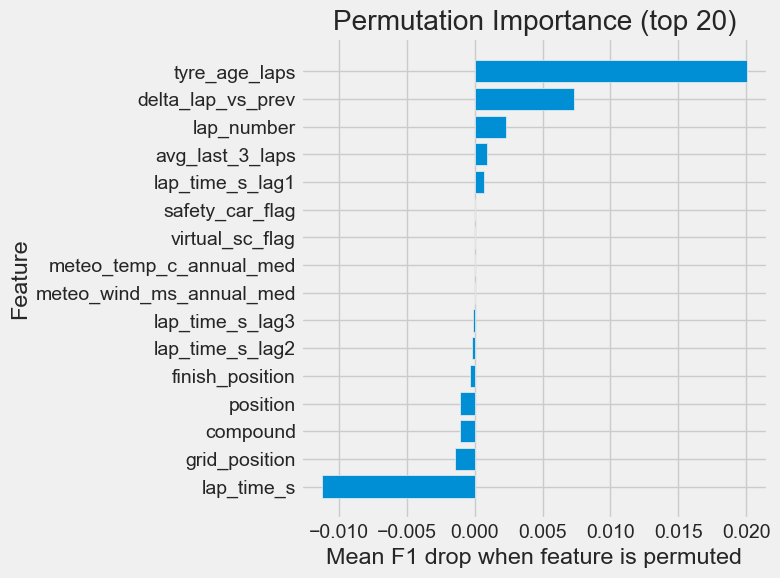

In [40]:
best_thr = 0.116  

imp = perm_importance_by_raw_feature(
    clf, X_test, y_test,
    raw_cols=X_test.columns.tolist(),
    n_repeats=15,
    seed=42,
    threshold=best_thr  
)

imp.head(15)
plot_perm_importance(imp, top_n=20)


In [41]:
df["pit_in_next2"] = ((df.groupby(["race_id","driver_code"])["pit_in_flag"].shift(-1).fillna(0) + 
                       df.groupby(["race_id","driver_code"])["pit_in_flag"].shift(-2).fillna(0)) > 0).astype(int)

In [42]:
df.head(20)

,race_id,year,circuit_name,driver_code,team,lap_number,position,lap_time_s,sector1_s,sector2_s,sector3_s,compound,tyre_age_laps,stint_id,pit_in_flag,pit_out_flag,safety_car_flag,virtual_sc_flag,grid_position,finish_position,pit_stop_duration_s,meteo_temp_c_annual_med,meteo_wind_ms_annual_med,lap_time_s_lag1,lap_time_s_lag2,lap_time_s_lag3,delta_lap_vs_prev,avg_last_3_laps,pit_in_next2
0,2024_bahrain,2024,Bahrain,ALB,Williams,1,11.0,103.888,NaN,44.007,24.378,SOFT,1.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,NaN,NaN,NaN,NaN,NaN,0
1,2024_bahrain,2024,Bahrain,ALB,Williams,2,11.0,98.826,31.419,43.106,24.301,SOFT,2.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,103.888,NaN,NaN,-5.062,103.888000,0
2,2024_bahrain,2024,Bahrain,ALB,Williams,3,11.0,98.507,31.002,43.081,24.424,SOFT,3.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,98.826,103.888,NaN,-0.319,101.357000,0
3,2024_bahrain,2024,Bahrain,ALB,Williams,4,11.0,98.422,31.023,43.007,24.392,SOFT,4.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,98.507,98.826,103.888,-0.085,100.407000,0
4,2024_bahrain,2024,Bahrain,ALB,Williams,5,11.0,98.509,31.049,43.027,24.433,SOFT,5.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,98.422,98.507,98.826,0.087,98.585000,0
5,2024_bahrain,2024,Bahrain,ALB,Williams,6,11.0,98.575,31.034,43.141,24.400,SOFT,6.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,98.509,98.422,98.507,0.066,98.479333,0
6,2024_bahrain,2024,Bahrain,ALB,Williams,7,11.0,98.971,31.498,43.186,24.287,SOFT,7.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,98.575,98.509,98.422,0.396,98.502000,0
7,2024_bahrain,2024,Bahrain,ALB,Williams,8,11.0,98.660,31.493,42.899,24.268,SOFT,8.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,98.971,98.575,98.509,-0.311,98.685000,0
8,2024_bahrain,2024,Bahrain,ALB,Williams,9,11.0,98.652,31.458,42.976,24.218,SOFT,9.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,98.660,98.971,98.575,-0.008,98.735333,0
9,2024_bahrain,2024,Bahrain,ALB,Williams,10,11.0,98.952,31.624,42.955,24.373,SOFT,10.0,1,0,0,0,0,13.0,15.0,NaN,28.9,14.8,98.652,98.660,98.971,0.300,98.761000,0


In [43]:
df.shape

(3374, 29)

In [44]:
df["circuit_name"].unique()

array(['Bahrain', 'Monaco', 'Monza'], dtype=object)

In [45]:
df.to_csv("data/gold/2024_Bahrain_Monaco_Monza.csv", index=False)